# Case Study for Facial Expression Recognition

### This project is impementing to identify Facial expression of the image passed into the model, it uses fer2013 dataset to train the CNN model, the File contains two columns emotions and pixel value, this data is send into the simple CNN model to train as a supervised learing,

### Once it learns the dataset, we use a certain percentage of that data to validate and check against the label, as part of training process we save the model to use to predict the model against the new image and identify the label

###  1) Load all the required library that will be required to run the project

In [1]:
#Load all dependancies
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torchvision.datasets as datasets
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import csv

### 2) This are helper method to plot the data to matplotlib, it shows a line chart and bar chart respectiely 

#### a) plot_training_metrics - This is used to show the loss and accuracies on the line graph for each iteration that will run on the training dataset

#### b) plot_emotion_distribution - this is a bar chart, it is used to show the statistics while loading the raw dataset from the file, it will plot a graph to show how the distribution of different emotions are there in the file.

In [2]:
#helper method to plot training metrics
def plot_training_metrics(num_epochs, train_losses, train_accuracies):
    
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def plot_emotion_distribution(df,x_label,y_label,title):

    # Flatten the height array
    height = df.value_counts().values.ravel()
    #plot a graph
    plt.bar(df.value_counts().index, height)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    #order of emotions 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral.
    plt.xticks(ticks=df.value_counts().index, labels=["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])
    plt.show()

### 3) Helper method to reduce the size of the dataset that was downloaded from fer2013 dataset, as constant traning and analysing may have to be done, so it will easy to work with small dataset at the beginning before running on the entire dataset.

#### a) reduce_training_data - this method will load the entire dataset from file and then it will take a sample based on the percentage we provide.

In [3]:
def reduce_training_data(input_csv, output_csv, percentage,random_state):
    # Load the dataset
    df = pd.read_csv(input_csv)

    # Create a new dataset with the specified percentage of data
    new_df = df.sample(frac=percentage, random_state=random_state)

    # Remove existing double quotes from the 'pixels' column and add a single double quote
    new_df['pixels'] = new_df['pixels'].str.replace(r'"', '')
    new_df['pixels'] = '"' + new_df['pixels'] + '"'

    # Save the new dataset without including the index column
    new_df.to_csv(output_csv, index=False, quoting=csv.QUOTE_NONE)
    return new_df

### 4) This method is used to show the statistics of the dataset that we are loading and will be using this in our model.

#### a) show_data_statistics - this will accept a pandas dataset that was loaded from the csv file and then will show all statistics needed for inital analysing, it will also call the plot graph from this to plot a bar graph. more statistics can be added if required to this method.

In [4]:
# Show Statistics on the total data
def show_data_statistics(df):
    #csv_file = './fer2013-dataset/train.csv'  #this is the large file that we will be working with
    #df = pd.read_csv(csv_file)

    # Display basic statistics about the DataFrame
    print("Data Statistics:")
    print(df.info())
    print(df.describe())

    #plot training data
    plot_emotion_distribution(df['emotion'],'Emotion','Count','Face Expression Distribution')

### 5) Helper class to load the dataset from the csv file, as the image are of size 48x48 and before sending the pixel value we also need to convert this into tensor as pytorch, This will use 48x48 and 1 as channel, i.e. grayscale. All the image in the dataset is in grayscale, so it is converting the same.

#### a) TransformDataset - This method will take a dataset which are more of string, it will convert that into numpy array to match the resolution size of required image size and then convert this into Tensor for pytorch to work with.


In [5]:
#Create definition for loading dataset from the file
class TransformDataset(Dataset):    
    def __init__(self, data, transform=None):
        #self.data = pd.read_csv(csv_path)
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        pixels = self.data.iloc[idx, 1].split(' ')  # Split the string of pixel values
        pixels = np.array([int(p) for p in pixels], dtype=np.uint8).reshape(48, 48, 1)
        emotion = int(self.data.iloc[idx, 0])
        if self.transform:
            pixels = self.transform(pixels)

        return pixels, emotion    

### 6) This is the architecture we will be using to train our model, we will be doing the following in this class

#### a) We are using 3 convolution layer, we will start with 1 and then the output will be 64 which will be passed to second layer, once this layer is completed, it will be input to the second conv layer and output will be 128, followed by the last layer will outputting 256, as we are working with image we are consdiering 256 pixels. The kernel size is a (3,3) block which will go over the each block of the image and then do a multiplication and then add the total output, this is basically to learn curves, edges or pattern in the image. as the model progreses it learn more and more about the image features.

#### b) once the convolution layer is completed, we will pass the output of the 3 conv layer into a fully connected layer in a flattened tensor, the three values we are seeing here is output of the 3 conv layer that was run previosly, the output of this fully connected layer1 will be again a sensor of size 1024 (note this can be modified and tried with different number, the more or less number will have the impact on how the model is learning) ,the second layer of the fully connected layer now take the input from the previous layer and then output the 7 classification that we actually need, the 7 classification is the different emotions that we are going to match in the second layer of Fully connected layer.

#### c) forward - this is the forward pass which will navigate from one layer to another layer, in this we are applying the activation function to each layer, for this we are using relu activation, once the conv layer is activated, it will pass to max pooling to reduce the spatial dimension of the feature and keeping the important one.  


#### d) Convolutional Architecture
![cnn architecture](ref/cnn_architecture.png)

In [6]:
# Define a custom CNN model for face emotion recognition

class ThreeConvLayer_CNN(nn.Module):
    def __init__(self, num_classes=7):
        super(ThreeConvLayer_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.fc1 = nn.Linear(256 * 6 * 6, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = nn.functional.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### 7) logic to train the model based on the architecture we have developed, 

#### a) in this we will set the hyperparameter to run the training in batches and number of epoch, this is the iteration we are doing this to learn features, it can be configured, the number should be decided and it should be validated at what point the results are converging, once we reach the model we should use that epoch number

#### b) the batch size is to run a given set of records in each epoch iteration, here we are giving 64, the more the number we give the more cpu time it will take, it is something we need to trial and error

#### c) when the loop is run as part of training process we will be calculating the loss function, the loss function will be more at the beginning, but as we start iterating the model will backpropate and the loss will reduce, this is again something we need to run and see how it is converging, some time too many iteration can also increase the error after it come down. we are using crossEntropy as we are doing a classification task, this is more appropriate for us.

#### d) as part of backpropagation we are doing a gradient descent to update the weight and biasis, for this we are using Adam (Adaptive Moment Estimation) optimizer

#### c) as we are doing the forward pass and back propagation, we are updating the losses and the accuracies into an array and using that to plot that into a graph for us to learn how our model is performing.

In [7]:
#training the model with hyper parameters
def train_facial_expression_cnn(train_dataset,train_loader,model_name_to_save,batch_size,epoch_iter): 
    # Create a list to store the training losses for each epoch
    train_losses = []
    train_accuracies = []

    # Hyperparameters
    batch_size = batch_size
    learning_rate = 0.001
    num_epochs = epoch_iter  

    # Load the data from the CSV file using pandas
    #csv_path = 'fer2013-dataset/small_train_data.csv'
    #data = pd.read_csv(csv_file)

    # Initialize the model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #todo: why this is not working in my google collab
    model = ThreeConvLayer_CNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)


    # Record start time
    start_time = time.time()

    # Training loop
    total_step = len(train_loader)
    total_samples = len(train_dataset)
    
    print(f"Total steps count : {total_step}")
    print(f"Total dataset count : {total_samples}")

    for epoch in range(num_epochs):
        # Create a variable to store the total loss for this epoch
        epoch_loss = 0.0
        correct_predictions = 0

        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Get the predicted labels and count correct predictions
            predicted = torch.argmax(outputs.data, 1)
            correct_predictions += (predicted == labels).sum().item()

            # Backward pass and then optimize
            optimizer.zero_grad()  #importan, we do not want to retain the value from previous epoch
            loss.backward()
            optimizer.step()

            # Add the loss for this batch to the epoch_loss
            epoch_loss += loss.item()

            #print at batch level after certain no or records in a batch, print the loss
            if (i+1) % total_step == 0:
                print(f"Step [{i+1}/{total_step}] completed for Epoch [{epoch+1}/{num_epochs}]...")
                #print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

        # Calculate the average loss for this epoch and append it to the list
        avg_epoch_loss = epoch_loss / len(train_loader)
        accuracy = (correct_predictions / len(train_dataset)) * 100


        train_losses.append(avg_epoch_loss)
        train_accuracies.append(accuracy)

    #Record end time
    end_time = time.time()

    print("Training finished!")
    
    # Save the trained model
    torch.save(model.state_dict(), model_name_to_save) #model nameto save is .pth file

    final_accuracy = correct_predictions / total_samples
    print(f"Final Training Accuracy: {final_accuracy*100:.2f}%")

    # Calculate total training time
    total_time = end_time - start_time
    print(f"Total training time: {total_time:.2f} seconds")

    plot_training_metrics(num_epochs, train_losses, train_accuracies)
    return model

### 8) Logic to validate the model that is trained before, in this we run the new set of data based on the model that was trained before, this data set will have the label and the pixel value and will be comparing the predicted with the label and calculate the accuracies 

In [8]:
# Testing the model on validation data
def validate_model(model,valdate_loader):
    num_records_to_show = 0

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #todo: why this is not working in my google collab
    with torch.no_grad():
        model.eval()  #set the model for evaluation

        correct = 0
        total = 0
        for i,(images, labels) in enumerate(validate_loader,1):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            predicted = torch.argmax(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i <= num_records_to_show:
                print(f"Record {i}: Predicted = {predicted[0].item()}, True Label = {labels[0].item()}")       

        print(f"Accuracy on validation data: {100 * correct / total:.2f}%")

### 9) method to predict a new data based on the model that we trained, this will predict the label for the image we are going to pass.

In [9]:
def predict_emotion(model_path, image_path):
    
    image = Image.open(image_path).convert('L')  # Convert to grayscale

    # Apply transformations to match the input requirements of the model
    transform = transforms.Compose([
        transforms.Resize((48, 48)),
        transforms.ToTensor()        
    ])

    # Apply the transformations to the image
    processed_image = transform(image).unsqueeze(0)
       
    # Load the model architecture
    model = ThreeConvLayer_CNN()

    # Load the saved model's state dictionary into the model
    model.load_state_dict(torch.load(model_path))
    model.eval()  
   
    # Make predictions on the preprocessed image
    with torch.no_grad():
        output = model(processed_image)

    
    probabilities = torch.softmax(output, dim=1) #last step softmax for classification..
    predicted_label = torch.argmax(probabilities, dim=1)
    
    emotion_labels = ['Angry', 'Happy', 'Sad', 'Neutral', 'Surprise', 'Fear', 'Disgust']
    predicted_emotion = emotion_labels[predicted_label.item()]

    return predicted_emotion

### 10) initial step before running our code, we are loading the file and reducing that, this is needed due to system limitation, before running against big data we can reduce to test our code. we are loading the ifle and showing the statistics

Data Statistics:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB
None
            emotion
count  28709.000000
mean       3.317427
std        1.876632
min        0.000000
25%        2.000000
50%        3.000000
75%        5.000000
max        6.000000


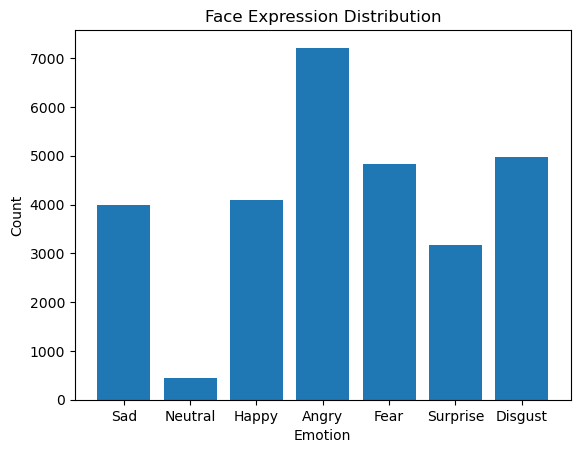

In [10]:
#wrapping all together

#reduce training data
input_csv_file = './fer2013-dataset/train.csv'
output_csv_file = './fer2013-dataset/small_train_data.csv'
percentage_to_keep = 1.0
reduced_train_data = reduce_training_data(input_csv_file, output_csv_file, percentage_to_keep,42)

#csv_path = 'fer2013-dataset/small_train_data.csv'
data = pd.read_csv(output_csv_file)
       
show_data_statistics(data)

### 11) Run the model by splitting between train and test and then first run the model and then validate using the test data,  this will ouput the graph and logs for us to understand how our model performed.

##### <span style="color:red"> Important : This will take lot of time to run, so be prepared before running this, you can skip this and use the model already saved with this step and run the prediction directly, unless this should be retrained </span>

Total steps count : 359
Total dataset count : 22967
Step [359/359] completed for Epoch [1/5]...
Step [359/359] completed for Epoch [2/5]...
Step [359/359] completed for Epoch [3/5]...
Step [359/359] completed for Epoch [4/5]...
Step [359/359] completed for Epoch [5/5]...
Training finished!
Final Training Accuracy: 42.43%
Total training time: 2399.54 seconds


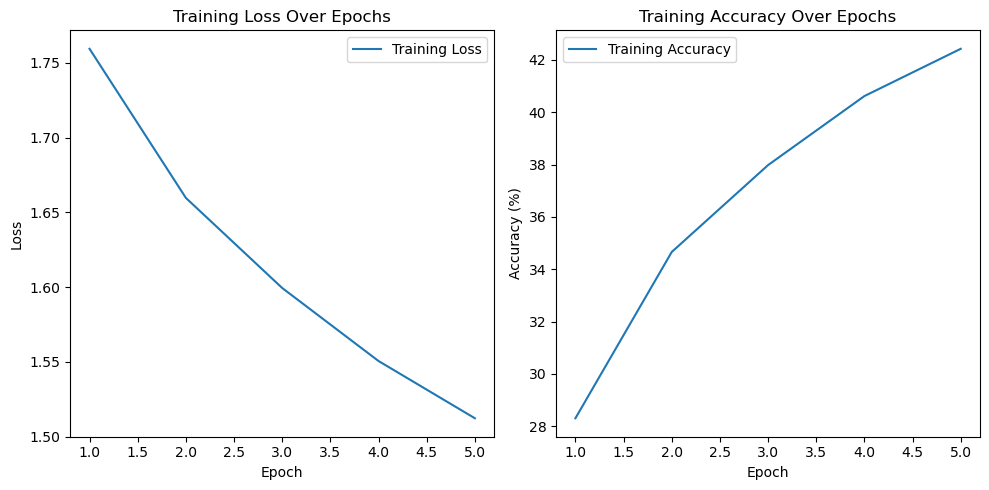

Accuracy on validation data: 42.28%


In [11]:
batch_size = 64
epoch = 5
# Split the data into train and test sets
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Create CustomDataset for train and test sets
train_dataset = TransformDataset(data=train_data, transform=transforms.ToTensor())
validate_dataset = TransformDataset(data=test_data, transform=transforms.ToTensor())

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)

saved_model_file = 'fer_cnn_model_large.pth'
trained_model = train_facial_expression_cnn(train_dataset,train_loader,saved_model_file,batch_size,epoch)

validate_model(trained_model,validate_loader)

### 12) Helper method to create images from the test file that was provided by fer2013, this will convert into image , save into a file and then use that for testing

In [12]:
def create_image_from_pixels(pixel_values, width, height, img_name):
    # Convert the pixel_values to a list of integers
    pixel_list = [int(pixel) for pixel in pixel_values.split()]

    # Create an image using the pixel_values
    image = Image.new('L', (width, height))
    image.putdata(pixel_list)

    # Save the image with the given name
    img_filename = f"{img_name}.png"
    image.save(img_filename)
    return img_filename

### 13) run a new set of image on the saved model and verify the label that is output by the predict_emotion method. for every run this will read random image from the file and run predictions on the same.

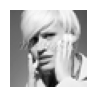

Predicted Emotion: Sad


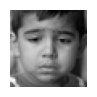

Predicted Emotion: Disgust


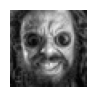

Predicted Emotion: Neutral


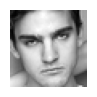

Predicted Emotion: Disgust


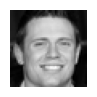

Predicted Emotion: Neutral


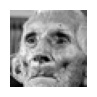

Predicted Emotion: Sad


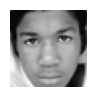

Predicted Emotion: Disgust


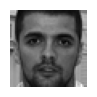

Predicted Emotion: Disgust


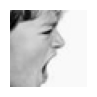

Predicted Emotion: Surprise


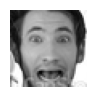

Predicted Emotion: Fear


In [13]:
#predict on the new dataset
model_path = './fer_cnn_model_large.pth'


data = pd.read_csv('./fer2013-dataset/test.csv')
random_rows = data.sample(n=10)

i=0
for index, row in random_rows.iterrows():
    i=i+1
    pixel_values = row["pixels"]   
    image_path = f"./temp_img/face_image_{i}"
    img_filename = create_image_from_pixels(pixel_values, 48, 48,image_path)  
    #run prediction on the newly created image
    predicted_emotion = predict_emotion(model_path, img_filename)  
    #generate image and show it in map
    image = Image.open(img_filename)
    plt.figure(figsize=(1, 1))
    plt.imshow(image, cmap='gray') 
    plt.axis('off')  
    plt.show()
    print(f"Predicted Emotion: {predicted_emotion}")
    